# Loan Performance Data Set - Classification of Loan Delinquency Status

In [1]:
import sys
import datetime as dt
import pandas as pd
import urllib.request
import zipfile, io
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn import neural_network
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

Preprocessing of Data

In [2]:
def preprocess(df_input):
    #Remove Spaces and Unknown
    df_input['CURRENT_LOAN_DELINQUENCY_STATUS'] = df_input['CURRENT_LOAN_DELINQUENCY_STATUS'].replace(['XX','   '],np.nan)
    df_input['REPURCHASE_FLAG'] = df_input['REPURCHASE_FLAG'].replace(['  '],'NA')
    df_input['MODIFICATION_FLAG'] = df_input['MODIFICATION_FLAG'].replace(['  '],'not_modfified')
    df_input['ZERO_BALANCE_CODE'] = df_input['ZERO_BALANCE_CODE'].replace(['  '],'NA')
    df_input['ZERO_BALANCE_EFFECTIVE_DATE'] = df_input['ZERO_BALANCE_EFFECTIVE_DATE'].replace(['      '],'NA')
    return df_input
def handleMissingData(df_input):
    #If null LOAN_SEQUENCE_NUMBER replace with NA
    df_input['LOAN_SEQUENCE_NUMBER'].fillna('NA',inplace=True)
    #If null replace CURRENT_ACTUAL_UPB with mean
    #df_input['CURRENT_ACTUAL_UPB'].fillna(0,inplace=True)
    #df_input['CURRENT_ACTUAL_UPB'].replace(0,df.Credit_Score.mean(),inplace=True)
    #If null Forward Fill or Bottom MONTHLY_REPORTING_PERIOD if null
    df_input.MONTHLY_REPORTING_PERIOD.fillna(method='ffill',inplace=True)
    df_input.MONTHLY_REPORTING_PERIOD.fillna(method='bfill',inplace=True)
    #Drop Rows of CURRENT_LOAN_DELINQUENCY_STATUS if Null
    df_input=df_input[~ df_input['CURRENT_LOAN_DELINQUENCY_STATUS'].isnull()]
    #Interpolate LOAN_AGE, REMAINING_MONTHS_TO_LEGAL_MATURITY
    df_input['LOAN_AGE'] = df_input['LOAN_AGE'].interpolate()
    df_input['REMAINING_MONTHS_TO_LEGAL_MATURITY'] = df_input['REMAINING_MONTHS_TO_LEGAL_MATURITY'].interpolate()
    #REPURCHASE_FLAG if null fill unknown
    df_input['REPURCHASE_FLAG'].fillna('unknown',inplace=True)
    #MODIFICATION_FLAG if null fill unknown
    df_input['MODIFICATION_FLAG'].fillna('unknown',inplace=True)
    #ZERO_BALANCE_CODE if null fill unknown
    df_input['ZERO_BALANCE_CODE'].fillna('unknown',inplace=True)
    #ZERO_BALANCE_EFFECTIVE_DATE if null fill NA    
    df_input['ZERO_BALANCE_EFFECTIVE_DATE'].fillna('NA',inplace=True)
    #CURRENT_INTEREST_RATE interpolate
    df_input['CURRENT_INTEREST_RATE'] = df_input['CURRENT_INTEREST_RATE'].interpolate()    
    #MI_RECOVERIES
    df_input['MI_RECOVERIES'].fillna(0,inplace=True)
    #NET_SALES_PROCEEDS 
    df_input['NET_SALES_PROCEEDS'].fillna(0,inplace=True)
    #NON_MI_RECOVERIES
    df_input['NON_MI_RECOVERIES'].fillna(0,inplace=True)
    #EXPENSES                      
    df_input['EXPENSES'].fillna(0,inplace=True)
    #Legal_Costs                   
    df_input['Legal_Costs'].fillna(0,inplace=True)
    #Maintenance_and_Preservation_Costs
    df_input['Maintenance_and_Preservation_Costs'].fillna(0,inplace=True)
    #Taxes_and_Insurance
    df_input['Taxes_and_Insurance'].fillna(0,inplace=True)
    #Miscellaneous_Expenses
    df_input['Miscellaneous_Expenses'].fillna(0,inplace=True)
    #Actual_Loss_Calculation
    df_input['Actual_Loss_Calculation'].fillna(0,inplace=True)
    #Modification_Cost
    df_input['Modification_Cost'].fillna(0,inplace=True)
    return df_input
def addNewColumnDelinquentorNonDelinquent(df):
    df['NEW_LOAN_DELINQUENCY_STATUS'] = pd.to_numeric(df.CURRENT_LOAN_DELINQUENCY_STATUS,errors = 'coerce')
    df['NEW_LOAN_DELINQUENCY_STATUS'].fillna(1, inplace = True)
    df_notZeros = df.NEW_LOAN_DELINQUENCY_STATUS[df['NEW_LOAN_DELINQUENCY_STATUS'] != 0]
    df_notZeros = df_notZeros/df_notZeros
    print(df_notZeros.shape)
    df_Zeros = df.NEW_LOAN_DELINQUENCY_STATUS[df['NEW_LOAN_DELINQUENCY_STATUS'] == 0]
    print(df_Zeros.shape)
    df_y = df_notZeros.append(df_Zeros)
    df['NEW_LOAN_DELINQUENCY_STATUS'] = df_y
    return df
def checkPercentageOfMissingData(df):
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    print(mis_val_percent)
def normalizeColumn(df_col):
    return preprocessing.normalize(df_col)
def createDFfromURL(fileURL):
    response = urllib.request.urlopen(fileURL)
    df = pd.DataFrame()
    if response.getcode()==200:
        data = response.read()
        if zipfile.is_zipfile(io.BytesIO(data)) == True:
            #print("Valid Zip file")
            z = zipfile.ZipFile(io.BytesIO(data))
            for file in z.namelist():
                #print(file)
                if file.find('_time_') != -1:
                    print("inside: "+file)
                    #print('Inside IF True')
                    csvFile = z.read(file)
                    df = pd.read_csv(io.BytesIO(csvFile),sep="|",header=None)
    print(df.shape)
    df.columns = ['LOAN_SEQUENCE_NUMBER','MONTHLY_REPORTING_PERIOD','CURRENT_ACTUAL_UPB','CURRENT_LOAN_DELINQUENCY_STATUS','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','REPURCHASE_FLAG','MODIFICATION_FLAG','ZERO_BALANCE_CODE','ZERO_BALANCE_EFFECTIVE_DATE','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','DUE_DATE_OF_LAST_PAID_INSTALLMENT','MI_RECOVERIES','NET_SALES_PROCEEDS','NON_MI_RECOVERIES','EXPENSES','Legal_Costs','Maintenance_and_Preservation_Costs','Taxes_and_Insurance','Miscellaneous_Expenses','Actual_Loss_Calculation','Modification_Cost','unknown']
    return df
def filterFrameWithRequiredFeatuers(df_input,df_input_test, ranking):
    df_new_train_x = pd.DataFrame()
    df_new_test_x = pd.DataFrame()
    print(df_new_test_x.head())
    for i in ranking:
        score,col_name  = i
        if score == 1:
            df_new_train_x[col_name] = df_input[col_name]
            df_new_test_x[col_name] = df_input_test[col_name]
    checkPercentageOfMissingData(df_new_train_x)
    checkPercentageOfMissingData(df_new_test_x)
    return (df_new_train_x,df_new_test_x)
def computeBestModel(list_of_model_and_accurancySocres):
    best_algo = None
    best_algo_accu_score = 0
    best_algo_model = None
    for value in list_of_model_and_accurancySocres:
        if best_algo != None:
            if value[1] > best_algo_accu_score:
                best_algo = value[0]
                best_algo_accu_score = value[1]
                best_algo_model = value[2] 
        else:
            best_algo = value[0]
            best_algo_accu_score = value[1]
            best_algo_model = value[2]
    print(best_algo + ' is best model with Accuracy Score of: ' +str(best_algo_accu_score))
    return (best_algo, best_algo_model)
def logisticRegression(x_train, y_train):
    print('Logistic Regression model computation has started')
    model = LogisticRegression()
    model.fit(x_train,y_train)
    print('Logistic Regression model computation has completed')    
    return (model, 'Logistic Regression')
    #return model
def predictAndEvaluate(model,x_test,y_test):
    # predict class labels for the test set
    print('Model testing has started')
    predicted = model.predict(x_test)
    probs = model.predict_proba(x_test)[:, 1]
    print('Model testing has completed')
    # generate evaluation metrics
    accu_score = metrics.accuracy_score(y_test, predicted)
    print('Accuracy Score: ' + str(accu_score))
    cm = metrics.confusion_matrix(y_test, predicted)
    print('Confusion Matrix:')
    print(cm)
    y_test = y_test.astype(np.float)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs)
    #Plot ROC curve
    %matplotlib inline
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return (accu_score,cm)
def randomForestClassifier(x_train, y_train):
    print('Random Forest model computation has started')    
    model = RandomForestClassifier(n_jobs=2)
    model = model.fit(x_train,y_train)
    print('Random Forest model computation has completed')    
    return (model, 'Random Forest Classifier')
def neuralNetClassifier(x_train, y_train):
    print('Neural Network based Classification model computation has started')     
    model = neural_network.MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    model = model.fit(x_train, y_train)
    print('Neural Network based Classification model computation has completed')     
    return (model,'Neural Network Classifier')
def svc(x_train, y_train):
    print('Support Vector Classification model computation has started')    
    model = svm.SVC(probability=True)
    model = model.fit(x_train, y_train) 
    print('Support Vector Classification model computation has completed')     
    return (model,'Support Vector Classification')
#Function to generate urlLIst for origination and next quarter URLs
def generateURLList(quarter,year):
    next_quarter = quarter +1
    next_year = year +1
    urlTrainList = []
    urlTestList = []
    train_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(year)+ ".zip"
    urlTrainList.append(train_url)
    if quarter == 4:
        quarter=1
        test_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(next_year)+ ".zip"
        urlTestList.append(test_url)
    else:
        test_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(next_quarter)+str(year)+ ".zip"
        urlTestList.append(test_url) 
    return (urlTrainList,urlTestList)
def addRowToDataFrame(confusion_matrix_input,y_values,col_names,output_matrix,quarter):
    counts,counts_1 = np.unique(y_values,return_counts=True)
    temp = [counts_1[1],confusion_matrix_input[0][1]+confusion_matrix_input[1][1],len(y_values),confusion_matrix_input[1][1],confusion_matrix_input[0][1]]
    temp = np.asarray(temp)
    output_matrix = output_matrix.append({'Quarter':quarter,'Number_of_Actual_Delinquents':temp[0], 'Number_of_predicted_delinquents':temp[1],'Number_of_records_in_dataset':temp[2],'Number_of_delinquents_properly_classified':temp[3],'Number_of_non- delinquents_improperly_classified_as_delinquents':temp[4]}, ignore_index=True)
    return output_matrix

In [3]:
def runMain(year, quarter):
    urlTrainList,urlTestList = generateURLList(year,quarter)
    print(urlTrainList[0])
    print(urlTestList[0])
    df = createDFfromURL(urlTrainList[0])
    df_test = createDFfromURL(urlTestList[0])
    df = df.head(100000)
    df_test = df_test.head(100000)
    #Preprocess Data, Handle Missing, Add NEW_LOAN_DELINQUENCY_STATUS 
    df = preprocess(df)
    df = handleMissingData(df)
    df = addNewColumnDelinquentorNonDelinquent(df)
    #Preprocess Data, Handle Missing, Add NEW_LOAN_DELINQUENCY_STATUS 
    df_test = preprocess(df_test)
    df_test = handleMissingData(df_test)
    df_test = addNewColumnDelinquentorNonDelinquent(df_test)
    checkPercentageOfMissingData(df)
    checkPercentageOfMissingData(df_test)
    df.dtypes
    #Factorize Data
    df['REPURCHASE_FLAG_FACTORIZE'] = pd.factorize(df['REPURCHASE_FLAG'])[0]
    df['MODIFICATION_FLAG_FACTORIZE'] = pd.factorize(df['MODIFICATION_FLAG'])[0]
    df['ZERO_BALANCE_CODE_FACTORIZE'] = pd.factorize(df['ZERO_BALANCE_CODE'])[0]
    df_test['REPURCHASE_FLAG_FACTORIZE'] = pd.factorize(df_test['REPURCHASE_FLAG'])[0]
    df_test['MODIFICATION_FLAG_FACTORIZE'] = pd.factorize(df_test['MODIFICATION_FLAG'])[0]
    df_test['ZERO_BALANCE_CODE_FACTORIZE'] = pd.factorize(df_test['ZERO_BALANCE_CODE'])[0]
    print(df.shape)
    print(df_test.shape)
    x_train = pd.DataFrame()
    x_train = df[['CURRENT_ACTUAL_UPB','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','MI_RECOVERIES','NON_MI_RECOVERIES','Actual_Loss_Calculation','Modification_Cost','REPURCHASE_FLAG_FACTORIZE','MODIFICATION_FLAG_FACTORIZE','ZERO_BALANCE_CODE_FACTORIZE','EXPENSES']]
    y_train = pd.DataFrame()
    y_train['NEW_LOAN_DELINQUENCY_STATUS'] = df['NEW_LOAN_DELINQUENCY_STATUS']
    y_train = np.ravel(y_train)
    x_train.dtypes
    x_test = pd.DataFrame()
    x_test = df_test[['CURRENT_ACTUAL_UPB','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','MI_RECOVERIES','NON_MI_RECOVERIES','Actual_Loss_Calculation','Modification_Cost','REPURCHASE_FLAG_FACTORIZE','MODIFICATION_FLAG_FACTORIZE','ZERO_BALANCE_CODE_FACTORIZE','EXPENSES']]
    y_test = pd.DataFrame()
    y_test['NEW_LOAN_DELINQUENCY_STATUS'] = df_test['NEW_LOAN_DELINQUENCY_STATUS']
    y_test = np.ravel(y_test)
    x_test.dtypes
    print(x_train.shape)
    print(x_test.shape)
    list_of_model_and_accurancySocres = []
    # Create the RFE object and rank each pixel
    lr = LogisticRegression()
    rfe = RFE(estimator=lr, n_features_to_select=5, step=2)
    rfe.fit(x_train.head(1000000),y_train[0:1000000])
    #ranking = rfe.ranking_.reshape(digits.images[0].shape)
    ranking = rfe.ranking_
    ranking_out = zip(map(lambda x: round(x, 4), rfe.ranking_), x_train.columns)
    print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_train.columns)))
    df_train_x,df_test_x = filterFrameWithRequiredFeatuers(x_train,x_test, ranking_out)
    print(df_train_x.shape)
    print(df_test_x.shape)
    type(y_test)
    counts,counts_1 = np.unique(y_test,return_counts=True)
    len(y_test)
    counts_1[0]
    col_names = ['Number_of_Actual_Delinquents','Number_of_predicted_delinquents','Number_of_records_in_dataset','Number_of_delinquents_properly_classified','Number_of_non- delinquents_improperly_classified_as_delinquents']
    out_matrix = pd.DataFrame(columns=col_names)
    model,algo_name = logisticRegression(df_train_x,y_train)
    accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
    list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
    out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,urlTestList[-10:-4])
    model, algo_name = randomForestClassifier(df_train_x, y_train)
    accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
    list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
    out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,urlTestList[-10:-4])
    model, algo_name = neuralNetClassifier(df_train_x, y_train)
    accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
    list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
    out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,urlTestList[-10:-4])
    best_algo_picked, best_algo_model = computeBestModel(list_of_model_and_accurancySocres)
    return (list(df_test_x.columns.values), best_algo_picked, best_algo_model)

https://freddiemac.embs.com/FLoan/Data/historical_data1_Q11999.zip
https://freddiemac.embs.com/FLoan/Data/historical_data1_Q21999.zip
inside: historical_data1_time_Q11999.txt


/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: DtypeWarning: Columns (3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(22324481, 24)
inside: historical_data1_time_Q21999.txt
(16506851, 24)
(4508,)
(95492,)
(3188,)
(96812,)
LOAN_SEQUENCE_NUMBER                   0.000
MONTHLY_REPORTING_PERIOD               0.000
CURRENT_ACTUAL_UPB                     0.000
CURRENT_LOAN_DELINQUENCY_STATUS        0.000
LOAN_AGE                               0.000
REMAINING_MONTHS_TO_LEGAL_MATURITY     0.000
REPURCHASE_FLAG                        0.000
MODIFICATION_FLAG                      0.000
ZERO_BALANCE_CODE                      0.000
ZERO_BALANCE_EFFECTIVE_DATE            0.000
CURRENT_INTEREST_RATE                  0.000
CURRENT_DEFERRED_UPB                   0.000
DUE_DATE_OF_LAST_PAID_INSTALLMENT     99.865
MI_RECOVERIES                          0.000
NET_SALES_PROCEEDS                     0.000
NON_MI_RECOVERIES                      0.000
EXPENSES                               0.000
Legal_Costs                            0.000
Maintenance_and_Preservation_Costs     0.000
Taxes_and_Insurance                    0

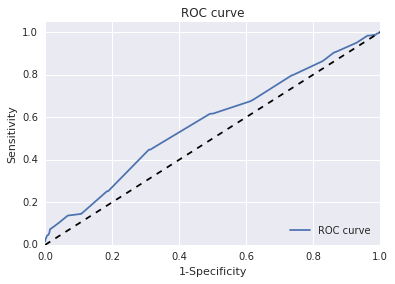

Random Forest model computation has started
Random Forest model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.96394
Confusion Matrix:
[[96326   486]
 [ 3120    68]]


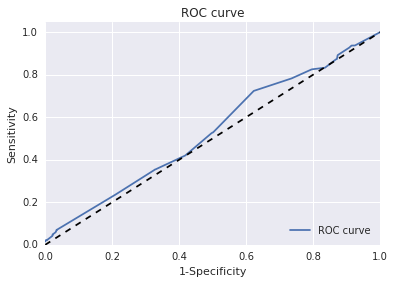

Neural Network based Classification model computation has started
Neural Network based Classification model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.96812
Confusion Matrix:
[[96812     0]
 [ 3188     0]]


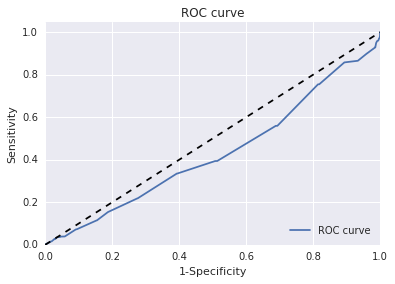

Logistic Regression is best model with Accuracy Score of: 0.96875


In [4]:
selected_featuers, best_algo_picked ,best_model_selected= runMain(1,1999)

In [5]:
best_model_selected

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
#Part 2 (Classification): Sub Section 2 starts here, generation of Delinquency Matrix from Q2 1999 to Q1 2016
def generateURLListfromQ11999toQ12016():
    urlList = []
    for year in range(1999,2017):
        for quarter in range(1,4):
            if year == 2016:
                urlList.append("https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(year)+ ".zip")
                break
            else:
                urlList.append("https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(year)+ ".zip")
    return urlList

In [7]:
urlList = generateURLListfromQ11999toQ12016()
col_names = ['Quarter','Number_of_Actual_Delinquents','Number_of_predicted_delinquents','Number_of_records_in_dataset','Number_of_delinquents_properly_classified','Number_of_non- delinquents_improperly_classified_as_delinquents']
out_matrix = pd.DataFrame(columns=col_names)

In [ ]:
urlList = urlList[1:]

https://freddiemac.embs.com/FLoan/Data/historical_data1_Q21999.zip
inside: historical_data1_time_Q21999.txt


/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(16506851, 24)
(517861,)
(15988990,)
Model testing has started
Model testing has completed
Accuracy Score: 0.968975487814
Confusion Matrix:
[[15988732      258]
 [  511859     6002]]


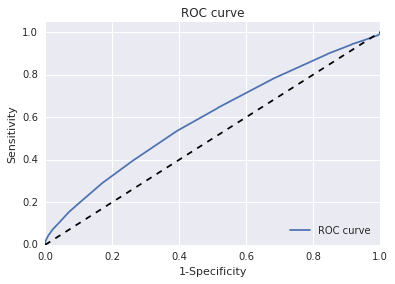

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   

   Number_of_non- delinquents_improperly_classified_as_delinquents  
0                                              258.0                
https://freddiemac.embs.com/FLoan/Data/historical_data1_Q31999.zip
inside: historical_data1_time_Q31999.txt
(8787718, 24)
(333852,)
(8453866,)
Model testing has started
Model testing has completed
Accuracy Score: 0.962106772202
Confusion Matrix:
[[8449052    4814]
 [ 328181    5671]]


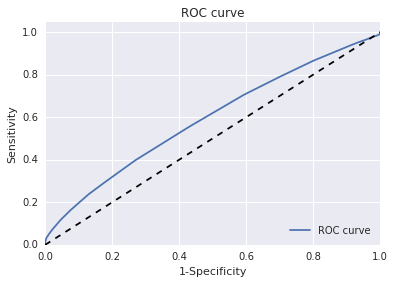

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   

   Number_of_non- delinquents_improperly_classified_as_delinquents  
0                                              258.0                
1                                             4814.0                
https://freddiemac.embs.com/FLoan/Data/historical_data1_Q12000.zip
inside: historical_data1_time_Q12000.txt
(3934992, 24)
(185036,)
(3749956,)
Model testing has started
Model testing has completed
Accuracy Score: 0.952949332553
Confusion Matrix:
[[3746418    3538]
 [ 181606    3430]]


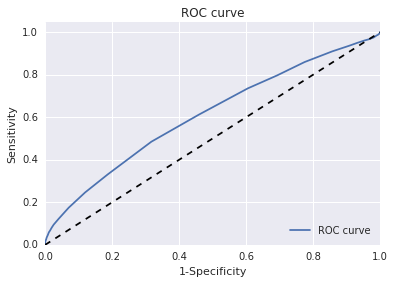

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   

   Number_of_non- delinquents_improperly_classified_as_delinquents  
0                                              258.0                
1                                             4814.0                
2                                             3538.0                
https://freddiemac.embs.com/FLoan/Data/historical_data1_Q22000.zip
inside: historical_data1_time_Q22000.tx

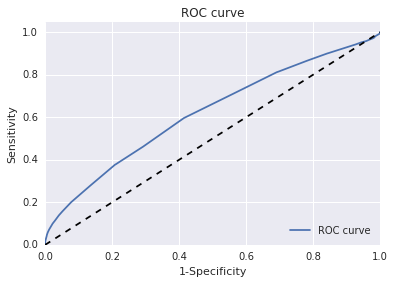

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   
3                     5050883.0                                     7955.0   

   Number_of_non- delinquents_improperly_classified_as_delinquents  
0                                              258.0                
1                                             4814.0                
2                    

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(5563230, 24)
(275084,)
(5288146,)
Model testing has started
Model testing has completed
Accuracy Score: 0.950101290078
Confusion Matrix:
[[5277957   10189]
 [ 267409    7675]]


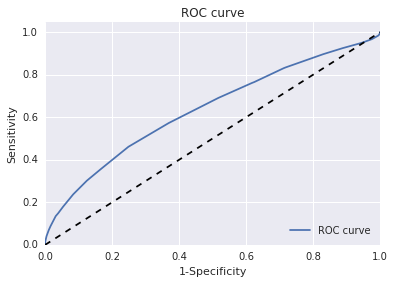

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   
3                     5050883.0                                     7955.0   
4                     5563230.0                                     7675.0   

   Number_of_non- delinquents_improperly_classified_as_delinquents  
0    

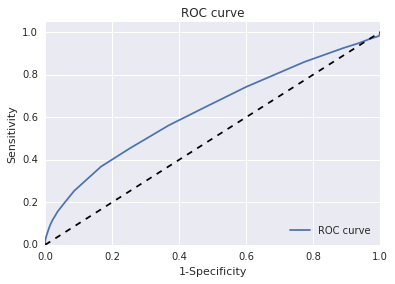

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   
5  Q12001                      489414.0                           7984.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   
3                     5050883.0                                     7955.0   
4                     5563230.0                                     7675.0   

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

(641091,)
(14842002,)
Model testing has started
Model testing has completed
Accuracy Score: 0.959221971992
Confusion Matrix:
[[14841763      239]
 [  631131     9960]]


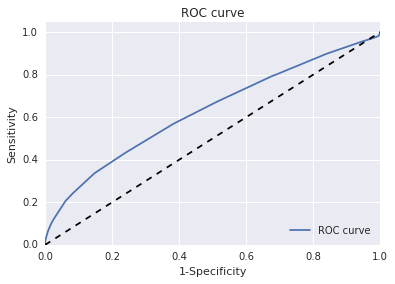

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   
5  Q12001                      489414.0                           7984.0   
6  Q22001                      641091.0                          10199.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   
3                     5050883.0                                     7955.0   
4

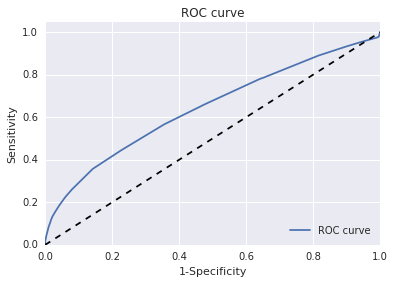

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   
5  Q12001                      489414.0                           7984.0   
6  Q22001                      641091.0                          10199.0   
7  Q32001                      604842.0                           9877.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2                     3934992.0                                     3430.0   
3  

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(13735743, 24)
(599044,)
(13136699,)
Model testing has started
Model testing has completed
Accuracy Score: 0.957113932606
Confusion Matrix:
[[13136337      362]
 [  588710    10334]]


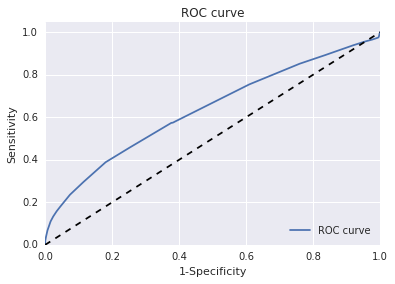

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   
5  Q12001                      489414.0                           7984.0   
6  Q22001                      641091.0                          10199.0   
7  Q32001                      604842.0                           9877.0   
8  Q12002                      599044.0                          10696.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1                     8787718.0                                     5671.0   
2    

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(11744456, 24)
(609017,)
(11135438,)
Model testing has started
Model testing has completed
Accuracy Score: 0.949040887806
Confusion Matrix:
[[11135058      380]
 [  598107    10910]]


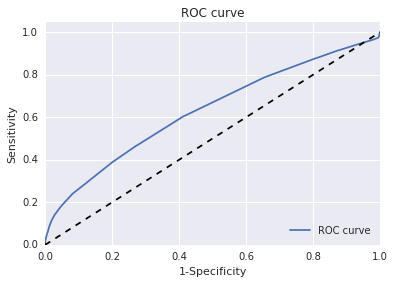

  Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0  Q21999                      517861.0                           6260.0   
1  Q31999                      333852.0                          10485.0   
2  Q12000                      185036.0                           6968.0   
3  Q22000                      254377.0                          20380.0   
4  Q32000                      275084.0                          17864.0   
5  Q12001                      489414.0                           7984.0   
6  Q22001                      641091.0                          10199.0   
7  Q32001                      604842.0                           9877.0   
8  Q12002                      599044.0                          10696.0   
9  Q22002                      609017.0                          11290.0   

   Number_of_records_in_dataset  Number_of_delinquents_properly_classified  \
0                    16506851.0                                     6002.0   
1      

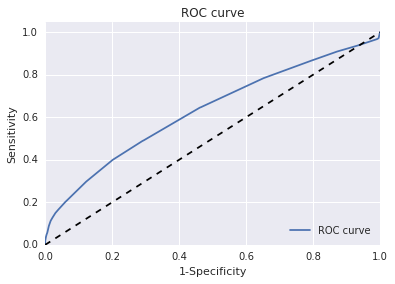

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   

    Number_of_records_in_dataset  Number_of_delinquents_properly_classified

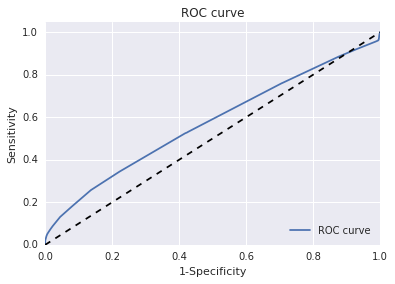

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

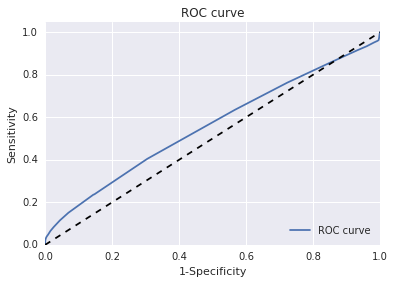

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

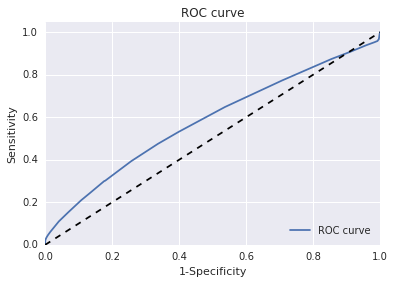

inside: historical_data1_time_Q12004.txt
(21103236, 24)
(780469,)
(20322767,)
Model testing has started
Model testing has completed
Accuracy Score: 0.963682441878
Confusion Matrix:
[[20322548      219]
 [  766199    14270]]


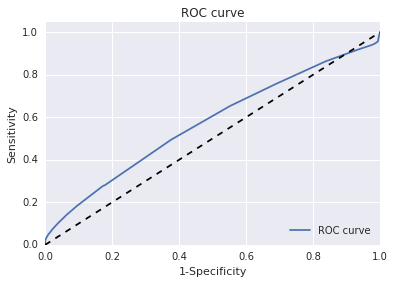

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

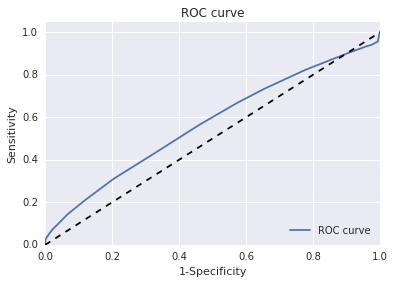

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

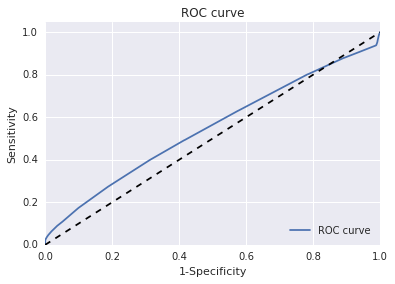

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

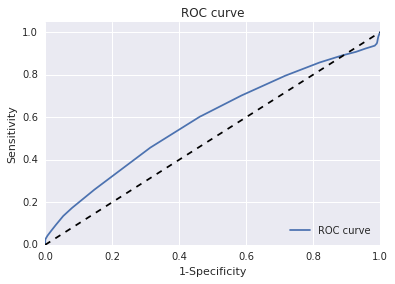

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

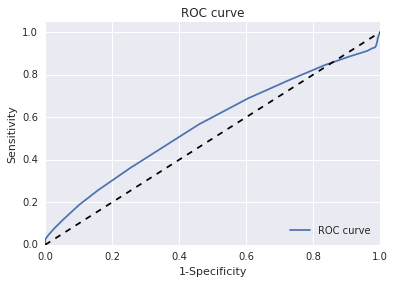

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

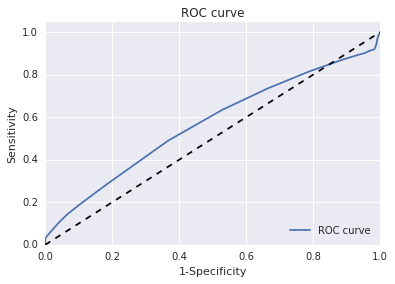

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

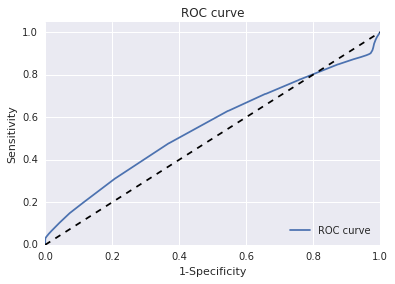

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

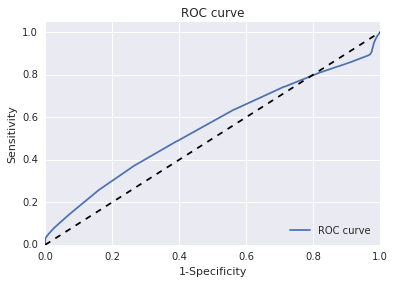

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

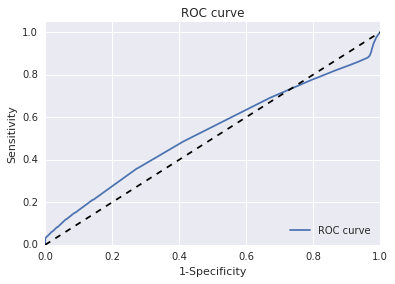

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

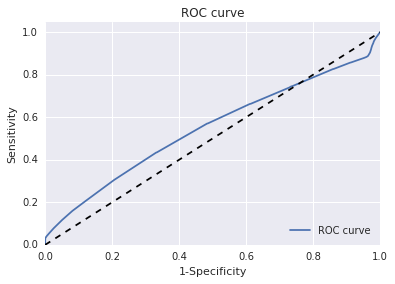

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

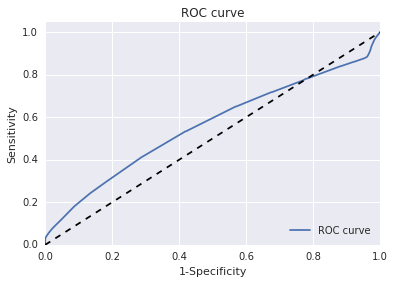

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

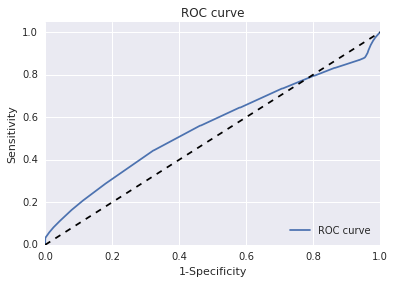

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

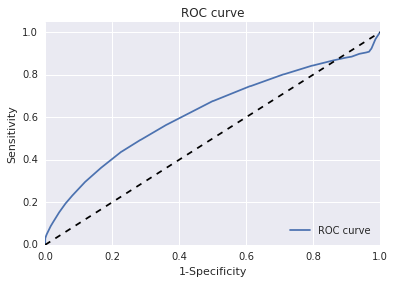

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

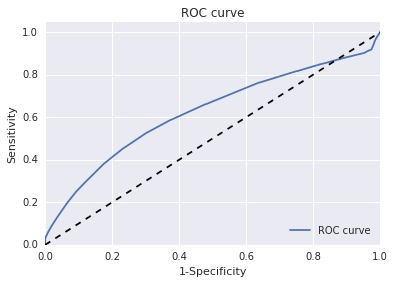

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

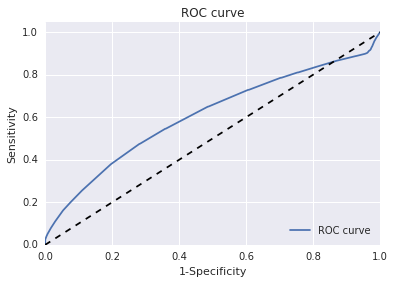

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

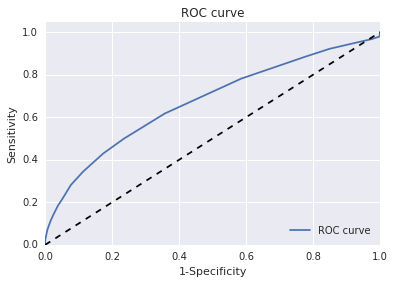

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

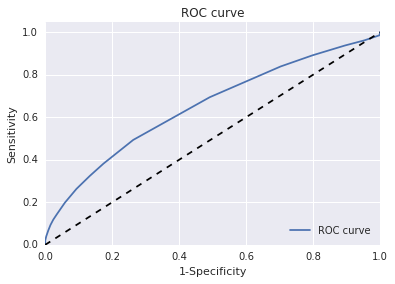

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

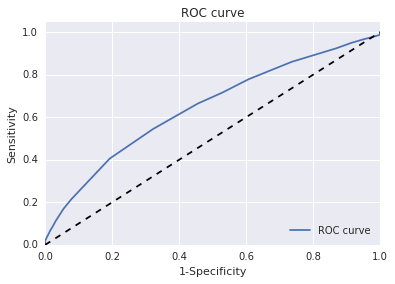

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

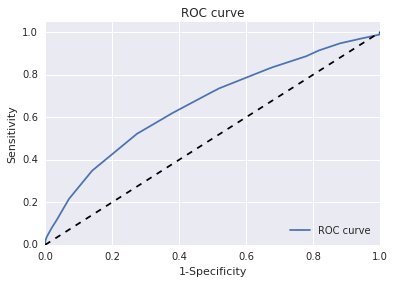

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

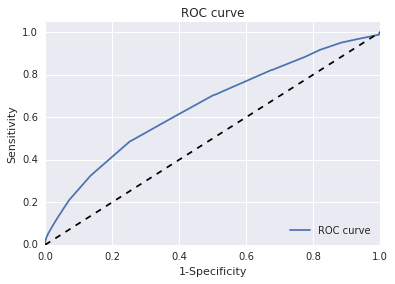

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

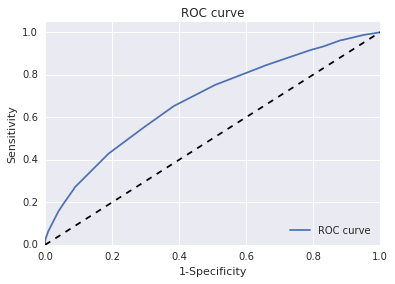

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

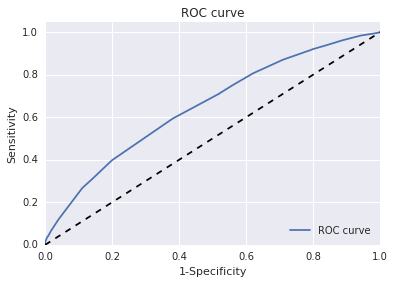

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

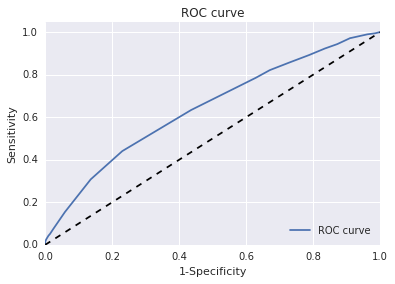

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

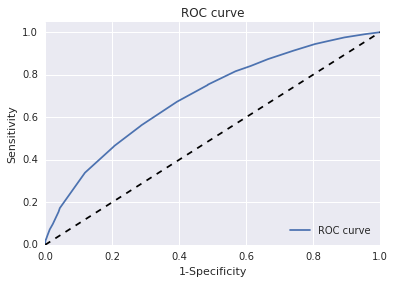

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

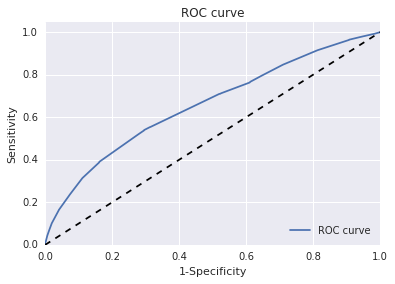

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

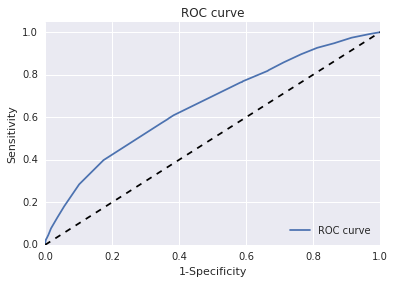

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

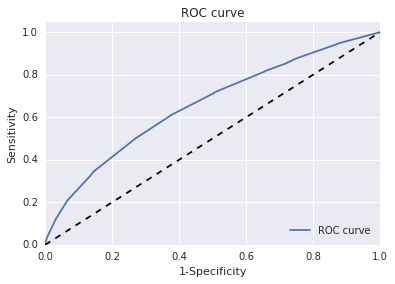

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

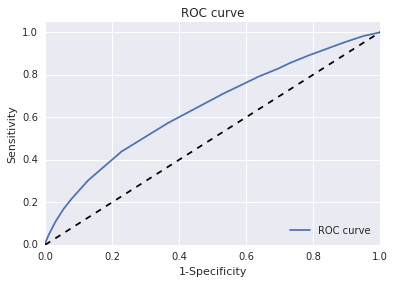

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

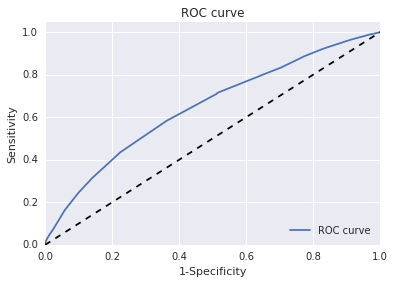

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

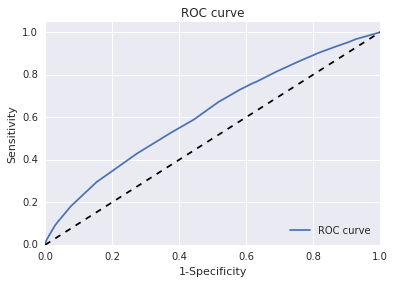

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

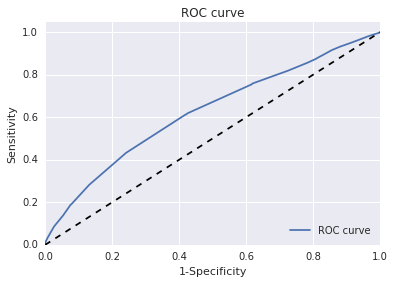

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

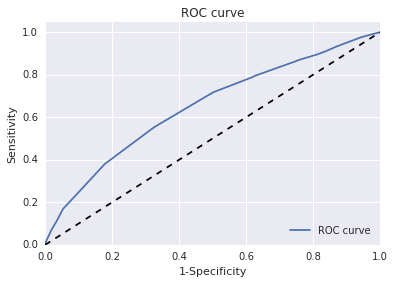

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

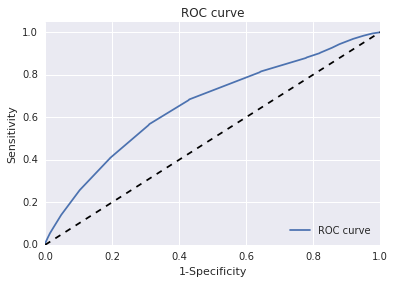

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

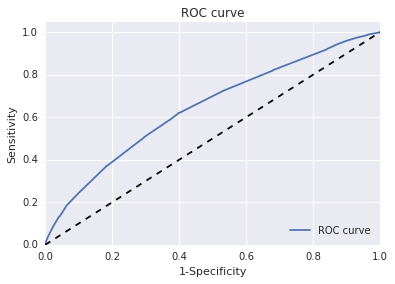

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(5603582, 24)
(14944,)
(5588638,)
Model testing has started
Model testing has completed
Accuracy Score: 0.99733331287
Confusion Matrix:
[[5588638       0]
 [  14943       1]]


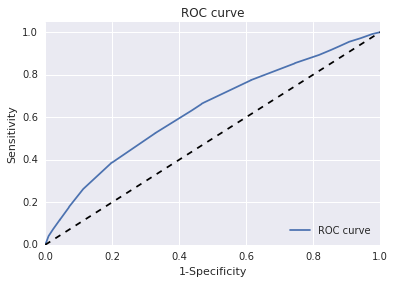

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(4043312, 24)
(11015,)
(4032297,)
Model testing has started
Model testing has completed
Accuracy Score: 0.997276242843
Confusion Matrix:
[[4032297       0]
 [  11013       2]]


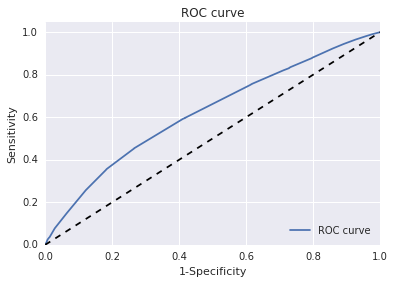

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(1854490, 24)
(3657,)
(1850833,)
Model testing has started
Model testing has completed
Accuracy Score: 0.99802802927
Confusion Matrix:
[[1850833       0]
 [   3657       0]]


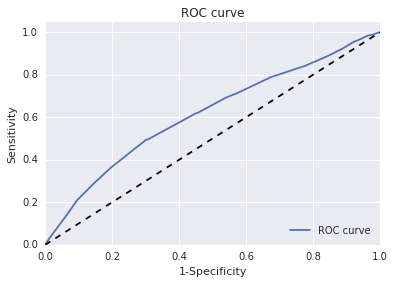

   Quarter  Number_of_Actual_Delinquents  Number_of_predicted_delinquents  \
0   Q21999                      517861.0                           6260.0   
1   Q31999                      333852.0                          10485.0   
2   Q12000                      185036.0                           6968.0   
3   Q22000                      254377.0                          20380.0   
4   Q32000                      275084.0                          17864.0   
5   Q12001                      489414.0                           7984.0   
6   Q22001                      641091.0                          10199.0   
7   Q32001                      604842.0                           9877.0   
8   Q12002                      599044.0                          10696.0   
9   Q22002                      609017.0                          11290.0   
10  Q32002                      718737.0                          13159.0   
11  Q12003                      697393.0                          13182.0   

In [ ]:
for urlToPredit in urlList:
    import gc
    gc.collect()
    print(urlToPredit)
    df = createDFfromURL(urlToPredit)
    #Preprocess Data, Handle Missing, Add NEW_LOAN_DELINQUENCY_STATUS 
    df = preprocess(df)
    df = handleMissingData(df)
    df = addNewColumnDelinquentorNonDelinquent(df)
    #Factorize Data
    df['REPURCHASE_FLAG_FACTORIZE'] = pd.factorize(df['REPURCHASE_FLAG'])[0]
    df['MODIFICATION_FLAG_FACTORIZE'] = pd.factorize(df['MODIFICATION_FLAG'])[0]
    df['ZERO_BALANCE_CODE_FACTORIZE'] = pd.factorize(df['ZERO_BALANCE_CODE'])[0]
    x_train = pd.DataFrame()
    x_train = df[['CURRENT_ACTUAL_UPB','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','MI_RECOVERIES','NON_MI_RECOVERIES','Actual_Loss_Calculation','Modification_Cost','REPURCHASE_FLAG_FACTORIZE','MODIFICATION_FLAG_FACTORIZE','ZERO_BALANCE_CODE_FACTORIZE','EXPENSES']]
    y_train = pd.DataFrame()
    y_train['NEW_LOAN_DELINQUENCY_STATUS'] = df['NEW_LOAN_DELINQUENCY_STATUS']
    y_train = np.ravel(y_train)
    df_test_x = x_train[selected_featuers]
    accu_score, confusion_matrix = predictAndEvaluate(best_model_selected, df_test_x, y_train)
    out_matrix = addRowToDataFrame(confusion_matrix,y_train,col_names,out_matrix,urlToPredit[-10:-4])
    print(out_matrix)

In [10]:
out_matrix

,Quarter,Number_of_Actual_Delinquents,Number_of_predicted_delinquents,Number_of_records_in_dataset,Number_of_delinquents_properly_classified,Number_of_non- delinquents_improperly_classified_as_delinquents
0,Q21999,517861.0,6260.0,16506851.0,6002.0,258.0
1,Q31999,333852.0,10485.0,8787718.0,5671.0,4814.0
2,Q12000,185036.0,6968.0,3934992.0,3430.0,3538.0
3,Q22000,254377.0,20380.0,5050883.0,7955.0,12425.0
4,Q32000,275084.0,17864.0,5563230.0,7675.0,10189.0
5,Q12001,489414.0,7984.0,11848219.0,7664.0,320.0
6,Q22001,641091.0,10199.0,15483093.0,9960.0,239.0
7,Q32001,604842.0,9877.0,13319377.0,9764.0,113.0
8,Q12002,599044.0,10696.0,13735743.0,10334.0,362.0
9,Q22002,609017.0,11290.0,11744455.0,10910.0,380.0
